In [113]:
import sys 
sys.path.append('..//utils')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from MiguelTK import *
import warnings
warnings.filterwarnings('ignore')

In [114]:
df = pd.read_csv('data/facturacion.csv')
df.head()

,fecha_de_factura,factura,codigo_de_stock,producto,cantidad,precio,id_del_cliente,ciudad
0,2021-12-05,537196,21811,CHRISTMAS HANGING HEART WITH BELL,1.0,1.25,c8a66fe3,Lleida
1,2020-12-16,539294,47574A,ENGLISH ROSE SCENTED HANGING FLOWER,1.0,4.25,7d08cdc9,Madrid
2,2020-10-18,571714,84951A,SET OF 4 PISTACHIO LOVEBIRD COASTER,NaN,NaN,df301f04,Oviedo
3,2022-09-08,566060,82484,WOOD BLACK BOARD ANT WHITE FINISH,2.0,16.63,a70cf1ee,Valencia
4,2022-12-06,537237,22208,WOOD STAMP SET THANK YOU,3.0,3.36,b0e56ea7,Alicante


In [115]:
df.dropna(subset='id_del_cliente',inplace=True)
df['fecha_de_factura'] = pd.to_datetime(df['fecha_de_factura'])

In [116]:
df.ciudad.unique()

array(['Lleida', 'Madrid', 'Oviedo', 'Valencia', 'Alicante', 'Móstoles',
       'Girona', 'Avilés', 'Castellón', 'Alcalá de Henares', 'Barcelona',
       'Gijón', 'madrid', 'Madrid '], dtype=object)

In [117]:
df['ciudad'] = (
    df
    ['ciudad']
    .str.lstrip()
    .str.rstrip()
    .str.upper()
)

In [118]:
df.ciudad.unique()

array(['LLEIDA', 'MADRID', 'OVIEDO', 'VALENCIA', 'ALICANTE', 'MÓSTOLES',
       'GIRONA', 'AVILÉS', 'CASTELLÓN', 'ALCALÁ DE HENARES', 'BARCELONA',
       'GIJÓN'], dtype=object)

In [119]:
customer_prof = pd.read_csv('data/customer.csv')[['Customer ID','Age','Gender','Subscription Status']]
df_integrado = pd.merge(
    df,
    customer_prof,
    how = 'inner',
    left_on = 'id_del_cliente',
    right_on = 'Customer ID'
).drop(columns='Customer ID')
df_integrado.head()

,fecha_de_factura,factura,codigo_de_stock,producto,cantidad,precio,id_del_cliente,ciudad,Age,Gender,Subscription Status
0,2021-12-05,537196,21811,CHRISTMAS HANGING HEART WITH BELL,1.0,1.25,c8a66fe3,LLEIDA,48,Male,Yes
1,2020-12-16,539294,47574A,ENGLISH ROSE SCENTED HANGING FLOWER,1.0,4.25,7d08cdc9,MADRID,29,Male,No
2,2020-10-18,571714,84951A,SET OF 4 PISTACHIO LOVEBIRD COASTER,NaN,NaN,df301f04,OVIEDO,41,Male,Yes
3,2022-09-08,566060,82484,WOOD BLACK BOARD ANT WHITE FINISH,2.0,16.63,a70cf1ee,VALENCIA,67,Female,No
4,2022-12-06,537237,22208,WOOD STAMP SET THANK YOU,3.0,3.36,b0e56ea7,ALICANTE,49,Male,No


In [120]:
df_integrado.rename(
    columns = {'Age':'age','Gender':'genero','Subscription Status':'suscripcion'},
    inplace = True
)

In [121]:
df_integrado['suscripcion'].unique()

array(['Yes', 'No'], dtype=object)

In [122]:
df_categoria = pd.read_csv('data/categoria_producto.csv')
df_categoria.head()

,Category,codigo_de_stock
0,Foodies,85123a
1,Moda,71053
2,Moda,84406B
3,Aventura,84029G
4,Tecnologia,84029E


In [123]:
df_integrado = pd.merge(
    df_integrado,
    df_categoria,
    how = 'inner',
    on = 'codigo_de_stock'
)
df_integrado.head()

,fecha_de_factura,factura,codigo_de_stock,producto,cantidad,precio,id_del_cliente,ciudad,age,genero,suscripcion,Category
0,2021-12-05,537196,21811,CHRISTMAS HANGING HEART WITH BELL,1.0,1.25,c8a66fe3,LLEIDA,48,Male,Yes,Moda
1,2021-12-05,537196,21811,CHRISTMAS HANGING HEART WITH BELL,1.0,1.25,c8a66fe3,LLEIDA,48,Male,Yes,Health & Wellness
2,2020-12-16,539294,47574A,ENGLISH ROSE SCENTED HANGING FLOWER,1.0,4.25,7d08cdc9,MADRID,29,Male,No,Tecnologia
3,2020-10-18,571714,84951A,SET OF 4 PISTACHIO LOVEBIRD COASTER,NaN,NaN,df301f04,OVIEDO,41,Male,Yes,Tecnologia
4,2022-09-08,566060,82484,WOOD BLACK BOARD ANT WHITE FINISH,2.0,16.63,a70cf1ee,VALENCIA,67,Female,No,Aventura


In [124]:
df_integrado['Category'].unique()

array(['Moda', 'Health & Wellness', 'Tecnologia', 'Aventura', 'Foodies'],
      dtype=object)

In [125]:
df = df_integrado

In [126]:
df['age_cat'] = pd.qcut(df['age'],5)

In [127]:
df['total'] = df['cantidad']*df['precio']

In [128]:
df['mes'] = df['fecha_de_factura'].dt.month.astype(str).str.zfill(2) + '/' + df['fecha_de_factura'].dt.year.astype(str)

In [129]:
df['n_compras'] = (
    df
    .groupby(['id_del_cliente','mes'],as_index=False)
    .transform('size')
)

In [130]:
for cat_var in ['ciudad','genero','suscripcion','Category','age_cat']:
    df[cat_var] = pd.Categorical(df[cat_var])

In [131]:
df = (
    df
    .query('cantidad > 0')
    .query('n_compras < n_compras.quantile(.95)')
    .query('cantidad < cantidad.quantile(.95)')
    .query('precio < precio.quantile(.95)')
)

## Análisis exploratorio de los datos

In [132]:
num_vars = df.select_dtypes('number').melt()
num_vars.head()

,variable,value
0,cantidad,1.0
1,cantidad,1.0
2,cantidad,1.0
3,cantidad,12.0
4,cantidad,5.0


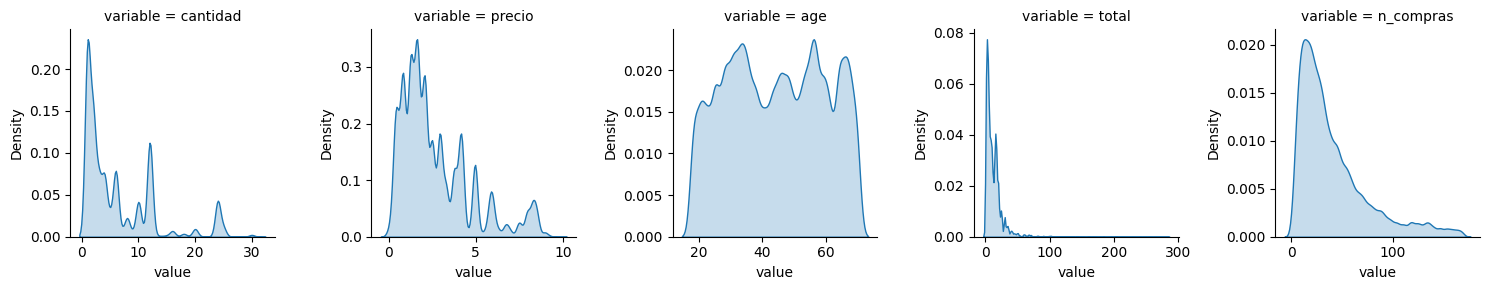

In [133]:
grid = sns.FacetGrid(num_vars,col='variable',sharex=False,sharey=False)
grid.map(sns.kdeplot,'value',fill=True)

In [134]:
cat_vars = df.select_dtypes('category').melt()
cat_vars.head()

,variable,value
0,ciudad,LLEIDA
1,ciudad,LLEIDA
2,ciudad,MADRID
3,ciudad,ALICANTE
4,ciudad,VALENCIA


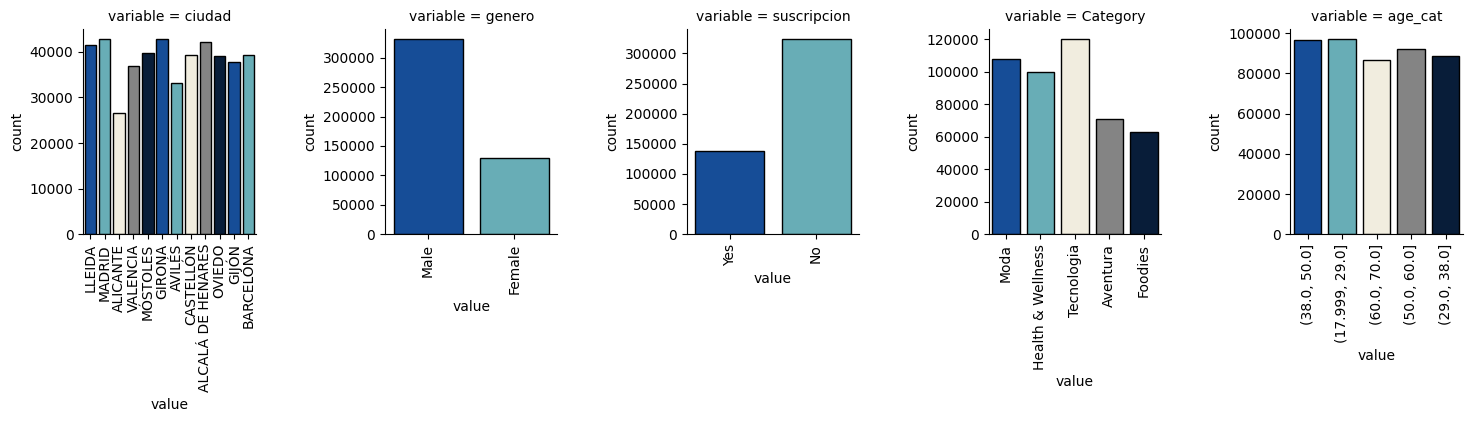

In [135]:
grid = sns.FacetGrid(cat_vars,col='variable',sharex=False,sharey=False)
grid.map(sns.countplot,'value',**kwargs)
grid.tick_params('x',rotation=90)

<Axes: xlabel='n_compras', ylabel='Density'>

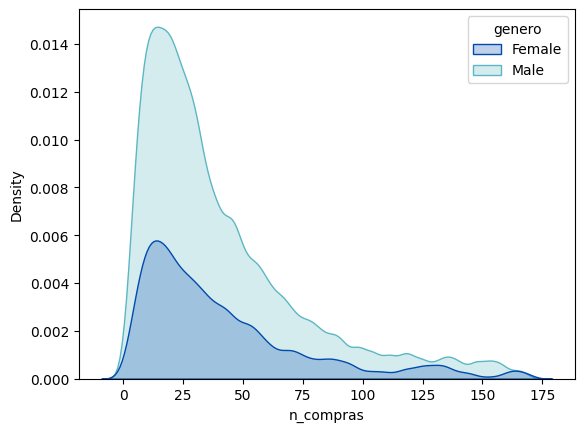

In [136]:
sns.kdeplot(
    data = df,
    x = 'n_compras',
    hue = 'genero',
    palette = palette,
    fill = True
)

<Axes: xlabel='n_compras', ylabel='Density'>

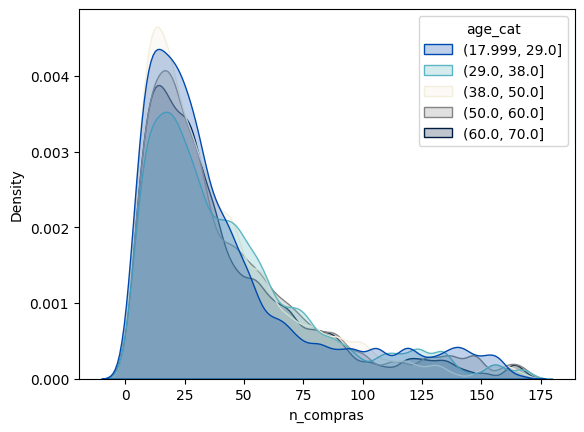

In [137]:
sns.kdeplot(
    data = df,
    x = 'n_compras',
    hue = 'age_cat',
    palette = palette,
    fill = True
)

<Axes: xlabel='precio', ylabel='Density'>

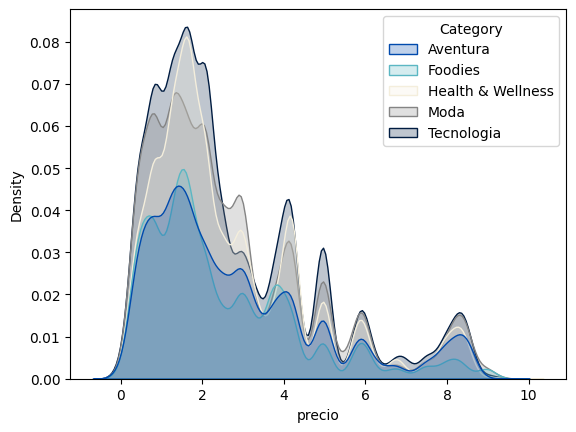

In [138]:
sns.kdeplot(
    data = df,
    x = 'precio',
    hue = 'Category',
    palette = palette,
    fill = True
)

<Axes: xlabel='n_compras', ylabel='Density'>

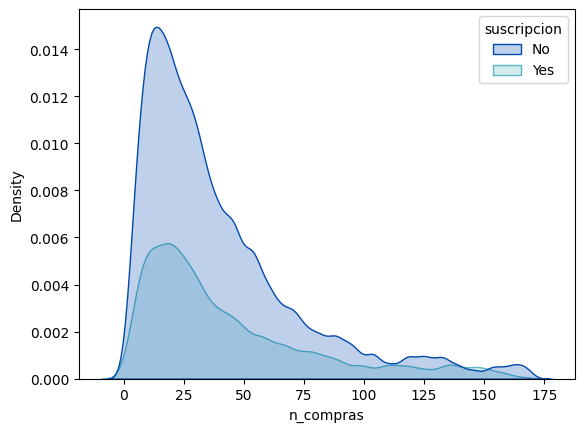

In [139]:
sns.kdeplot(
    data = df,
    x = 'n_compras',
    hue = 'suscripcion',
    palette = palette,
    fill = True
)

## Análisis de cohortes

In [140]:
primera_compra = (
    df
    .groupby('id_del_cliente')
    ['fecha_de_factura']
    .transform('min')
)

In [141]:
cohort_month = primera_compra.dt.month
cohort_year = primera_compra.dt.year
df['mes_cohorte'] = cohort_month.astype(str).str.zfill(2) + '/' + cohort_year.astype(str)
month_diff = df['fecha_de_factura'].dt.month - cohort_month
year_diff = df['fecha_de_factura'].dt.year - cohort_year
df['cohort_index'] = year_diff * 12 + month_diff

In [142]:
df.head()

,fecha_de_factura,factura,codigo_de_stock,producto,cantidad,precio,id_del_cliente,ciudad,age,genero,suscripcion,Category,age_cat,total,mes,n_compras,mes_cohorte,cohort_index
0,2021-12-05,537196,21811,CHRISTMAS HANGING HEART WITH BELL,1.0,1.25,c8a66fe3,LLEIDA,48,Male,Yes,Moda,"(38.0, 50.0]",1.25,12/2021,26,01/2020,23
1,2021-12-05,537196,21811,CHRISTMAS HANGING HEART WITH BELL,1.0,1.25,c8a66fe3,LLEIDA,48,Male,Yes,Health & Wellness,"(38.0, 50.0]",1.25,12/2021,26,01/2020,23
2,2020-12-16,539294,47574A,ENGLISH ROSE SCENTED HANGING FLOWER,1.0,4.25,7d08cdc9,MADRID,29,Male,No,Tecnologia,"(17.999, 29.0]",4.25,12/2020,23,01/2020,11
6,2021-05-08,552309,21094,SET/6 RED SPOTTY PAPER PLATES,12.0,0.85,4f289506,ALICANTE,64,Male,Yes,Tecnologia,"(60.0, 70.0]",10.20,05/2021,25,01/2020,16
7,2023-06-20,557426,22804,CANDLEHOLDER PINK HANGING HEART,5.0,2.95,54e1bf15,VALENCIA,25,Male,No,Aventura,"(17.999, 29.0]",14.75,06/2023,10,02/2020,40


### Agrupación por fechas de primera compra

In [143]:
cohortes_fecha = (
    df
    .pivot_table(
        index = 'mes_cohorte',
        columns = 'cohort_index',
        values = 'id_del_cliente',
        aggfunc = 'nunique'
    )
)
cohortes_fecha = cohortes_fecha.divide(cohortes_fecha[0],axis=0)
cohortes_fecha.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
mes_cohorte,,,,,,,,,,,,,,,,,,,,,
01/2020,1.0,0.621928,0.718336,0.678639,0.739130,0.716446,0.697543,0.682420,0.797732,0.805293,...,0.725898,0.684310,0.746692,0.706994,0.712665,0.682420,0.807183,0.818526,0.860113,0.848771
01/2021,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02/2020,1.0,0.645161,0.612903,0.698925,0.672043,0.634409,0.655914,0.784946,0.752688,0.822581,...,0.596774,0.693548,0.688172,0.655914,0.655914,0.768817,0.763441,0.817204,0.811828,NaN
02/2022,1.0,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03/2020,1.0,0.491379,0.534483,0.534483,0.517241,0.448276,0.534483,0.629310,0.681034,0.672414,...,0.560345,0.534483,0.517241,0.491379,0.551724,0.646552,0.681034,0.646552,NaN,NaN


Text(0.5, 1.0, 'Número de clientes diferentes desde el primer mes de compra')

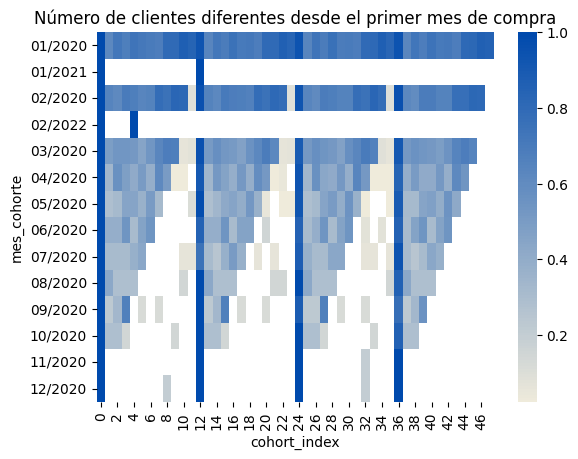

In [144]:
sns.heatmap(
    cohortes_fecha,
    cmap = cmap,
    center = 0,
    vmax = 1
)
plt.title('Número de clientes diferentes desde el primer mes de compra')

In [145]:
cohortes_fecha = (
    df
    .pivot_table(
        index = 'mes_cohorte',
        columns = 'cohort_index',
        values = 'id_del_cliente',
        aggfunc = 'count'
    )
)
cohortes_fecha = cohortes_fecha.divide(cohortes_fecha[0],axis=0)
cohortes_fecha.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
mes_cohorte,,,,,,,,,,,,,,,,,,,,,
01/2020,1.0,0.526642,0.657742,0.576497,0.715774,0.663941,0.773674,0.623978,0.992614,1.239515,...,0.672250,0.565286,0.727381,0.641256,0.797942,0.634133,0.986943,1.228172,1.467027,1.119625
01/2021,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02/2020,1.0,0.786237,0.556369,0.836018,0.911664,0.765251,0.912640,1.212787,1.260615,1.575403,...,0.554905,0.867740,0.860420,0.742801,0.895559,1.232308,1.288921,1.667155,1.204002,NaN
02/2022,1.0,NaN,NaN,NaN,0.500000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03/2020,1.0,0.556513,0.550766,0.795977,0.712644,0.667625,0.804598,0.993295,1.399425,0.961686,...,0.574713,0.784483,0.767241,0.683908,0.771073,1.002874,1.473180,0.805556,NaN,NaN


Text(0.5, 1.0, 'Número de compras desde el primer mes de compra')

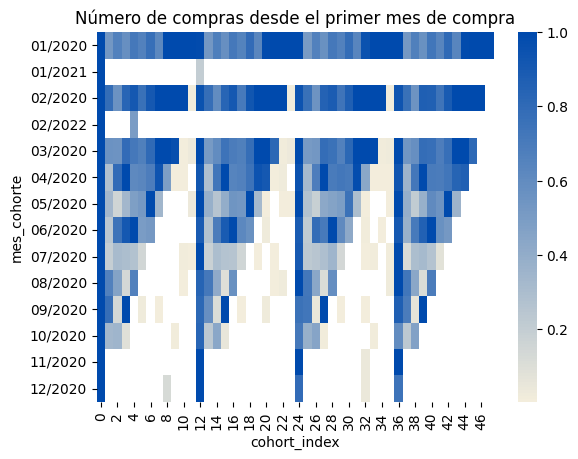

In [146]:
sns.heatmap(
    cohortes_fecha,
    cmap = cmap,
    center = 0,
    vmax = 1
)
plt.title('Número de compras desde el primer mes de compra')

In [147]:
cohortes_fecha = (
    df
    .pivot_table(
        index = 'mes_cohorte',
        columns = 'cohort_index',
        values = 'total',
        aggfunc = 'mean'
    )
)
cohortes_fecha = cohortes_fecha.divide(cohortes_fecha[0],axis=0)
cohortes_fecha.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
mes_cohorte,,,,,,,,,,,,,,,,,,,,,
01/2020,1.0,1.106495,1.061685,1.039175,1.209233,1.103140,1.036097,1.236410,1.205243,1.068811,...,1.054986,1.049947,1.183087,1.114758,1.000447,1.179647,1.228419,1.091789,1.118479,1.11551
01/2021,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02/2020,1.0,0.950270,0.988095,1.005562,0.961984,1.000116,1.053297,1.114210,1.022000,0.948600,...,0.948748,0.968460,0.974254,1.021426,1.021891,1.135630,1.077454,0.928193,1.096725,NaN
02/2022,1.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03/2020,1.0,0.846214,1.190627,0.978005,1.000129,0.905940,0.953284,0.962027,0.927780,1.033551,...,1.188150,0.947496,0.830884,0.933762,0.969691,0.907892,0.848634,1.015938,NaN,NaN


Text(0.5, 1.0, 'Media del total de la factura')

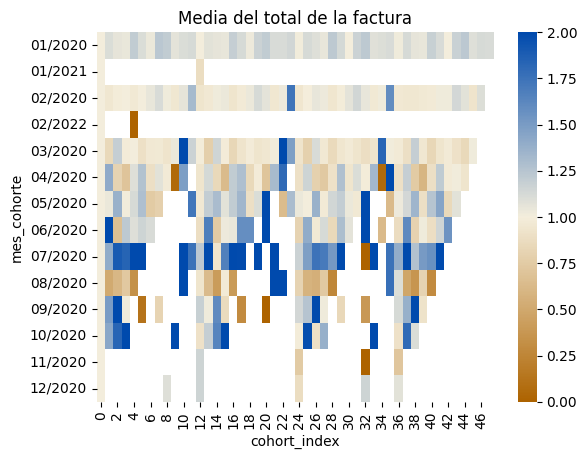

In [148]:
sns.heatmap(
    cohortes_fecha,
    cmap = cmap,
    center = 1,
    vmax = 2,
    vmin = 0
)
plt.title('Media del total de la factura')

<Axes: xlabel='cohort_index', ylabel='num_clientes'>

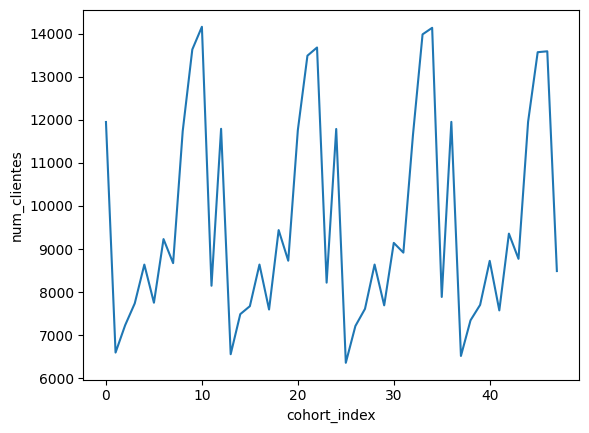

In [174]:
df_ = (
    df
    .groupby('cohort_index',as_index = False)
    ['id_del_cliente']
    .size()
    .rename(columns={'size':'num_clientes'})
)
sns.lineplot(
    data = df_,
    x = 'cohort_index',
    y = 'num_clientes'
)

<Axes: xlabel='cohort_index', ylabel='n_compras'>

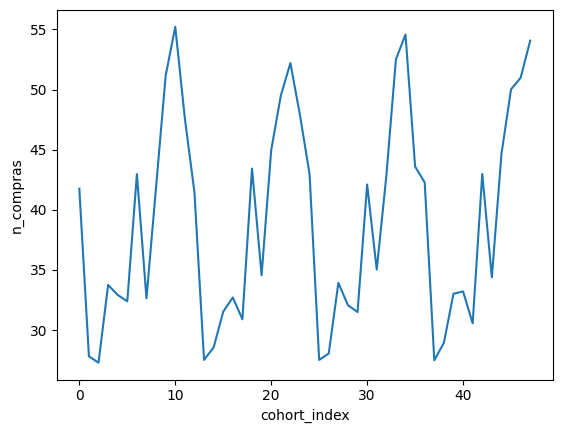

In [179]:
df_ = (
    df
    .groupby('cohort_index',as_index = False)
    ['n_compras']
    .mean()
)

sns.lineplot(
    data = df_,
    x = 'cohort_index',
    y = 'n_compras'
)

### Agrupación por ciudad

In [86]:
cohortes_ciudad = (
    df
    .pivot_table(
        index = 'ciudad',
        columns = 'cohort_index',
        values = 'id_del_cliente',
        aggfunc = 'nunique'
    )
)
cohortes_ciudad = cohortes_ciudad.divide(cohortes_ciudad[0],axis=0)
cohortes_ciudad.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
ciudad,,,,,,,,,,,,,,,,,,,,,
ALCALÁ DE HENARES,1.0,0.734940,0.746988,0.710843,0.771084,0.734940,0.759036,0.722892,0.783133,0.807229,...,0.746988,0.722892,0.746988,0.710843,0.759036,0.722892,0.807229,0.783133,0.734940,0.542169
ALICANTE,1.0,0.550725,0.637681,0.666667,0.666667,0.695652,0.681159,0.681159,0.753623,0.594203,...,0.608696,0.666667,0.637681,0.695652,0.652174,0.623188,0.695652,0.579710,0.637681,0.449275
AVILÉS,1.0,0.675676,0.716216,0.743243,0.729730,0.608108,0.662162,0.689189,0.797297,0.770270,...,0.743243,0.743243,0.743243,0.608108,0.702703,0.702703,0.797297,0.716216,0.648649,0.486486
BARCELONA,1.0,0.602564,0.743590,0.666667,0.679487,0.705128,0.730769,0.743590,0.769231,0.730769,...,0.705128,0.641026,0.628205,0.666667,0.705128,0.628205,0.743590,0.756410,0.705128,0.602564
CASTELLÓN,1.0,0.621053,0.600000,0.663158,0.652632,0.578947,0.631579,0.600000,0.715789,0.736842,...,0.589474,0.589474,0.684211,0.610526,0.631579,0.589474,0.684211,0.747368,0.610526,0.536842


<Axes: xlabel='cohort_index', ylabel='ciudad'>

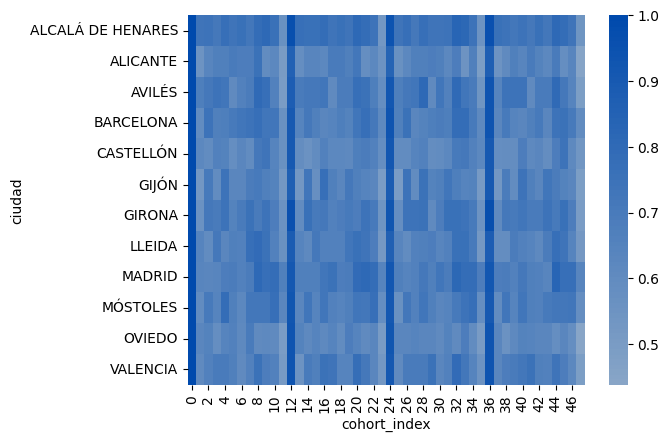

In [87]:
sns.heatmap(
    cohortes_ciudad,
    cmap = cmap,
    center = 0,
    vmax = 1
)

In [159]:
cohortes_ciudad = (
    df
    .pivot_table(
        index = 'ciudad',
        columns = 'cohort_index',
        aggfunc = 'size'
    )
)
cohortes_ciudad = cohortes_ciudad.divide(cohortes_ciudad.shift(axis=1))
cohortes_ciudad.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
ciudad,,,,,,,,,,,,,,,,,,,,,
ALCALÁ DE HENARES,NaN,0.671053,0.947210,0.979299,1.341463,0.894545,0.922764,1.044053,1.765120,0.923506,...,0.833568,1.123519,1.242470,0.932121,0.881664,1.117994,1.635884,0.946774,1.204429,0.546676
ALICANTE,NaN,0.449007,1.817109,0.847403,0.931034,0.967078,1.129787,0.613936,1.990798,1.161787,...,2.187943,0.928687,0.841187,0.902490,1.310345,0.517544,2.288136,1.186667,0.943820,0.578042
AVILÉS,NaN,0.374033,1.234483,1.191806,1.201563,0.576073,1.024831,1.517621,1.042090,1.380223,...,1.193258,1.158192,1.188618,0.577291,1.120853,1.460888,0.956585,1.438729,1.089380,0.503861
BARCELONA,NaN,0.393110,1.247191,0.981982,1.201835,1.236641,0.854321,0.937861,1.351310,1.191562,...,1.185031,0.966667,1.112523,1.298532,0.894472,0.936798,1.544228,1.054369,1.071823,0.858247
CASTELLÓN,NaN,0.541880,0.869085,1.038113,1.382867,1.128951,0.821948,0.945504,1.105187,1.672751,...,0.906646,0.891798,1.483366,0.941953,1.088235,0.870013,1.029586,1.580460,1.055455,0.663221


<Axes: xlabel='cohort_index', ylabel='ciudad'>

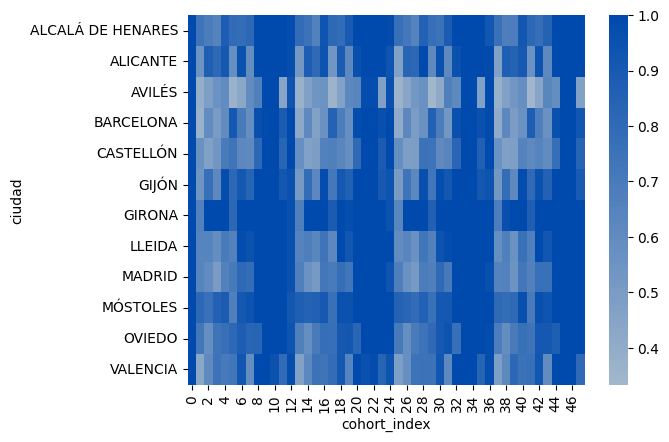

In [106]:
sns.heatmap(
    cohortes_ciudad,
    cmap = cmap,
    center = 0,
    vmax = 1
)

In [111]:
cohortes_ciudad = (
    df
    .pivot_table(
        index = 'ciudad',
        columns = 'cohort_index',
        values = 'total',
        aggfunc = 'mean'
    )
)
cohortes_ciudad = cohortes_ciudad.divide(cohortes_ciudad[0],axis=0)
cohortes_ciudad.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
ciudad,,,,,,,,,,,,,,,,,,,,,
ALCALÁ DE HENARES,1.0,1.038839,0.968523,1.032961,0.887043,1.097882,1.627060,1.460055,1.016173,0.878586,...,0.922363,1.169304,0.934917,0.914001,1.148488,1.311448,1.054123,0.859450,1.056904,0.358823
ALICANTE,1.0,1.062109,1.731589,1.055886,1.121791,1.916255,1.089018,1.853149,1.676909,1.391820,...,1.967800,1.109022,1.311897,2.009622,1.145273,1.682356,1.806416,1.580460,1.379606,1.593484
AVILÉS,1.0,1.260246,1.356487,0.907458,1.358392,1.006278,1.032886,0.835444,1.291228,0.942861,...,1.425876,0.994337,1.218350,0.953442,1.097093,1.011157,1.113832,0.652501,1.109300,1.238773
BARCELONA,1.0,0.846407,1.069653,1.603147,2.017061,0.799526,1.093237,1.173581,1.098250,0.959978,...,1.524284,0.991571,1.576740,0.705376,0.857822,0.305884,0.923204,1.102181,0.902996,1.083537
CASTELLÓN,1.0,0.878293,1.753588,0.895898,1.414954,1.045560,0.940038,0.839906,1.542546,0.908517,...,0.579606,0.770764,0.807724,1.163434,0.988030,0.652573,1.067602,0.861730,0.945422,0.790551


<Axes: xlabel='cohort_index', ylabel='ciudad'>

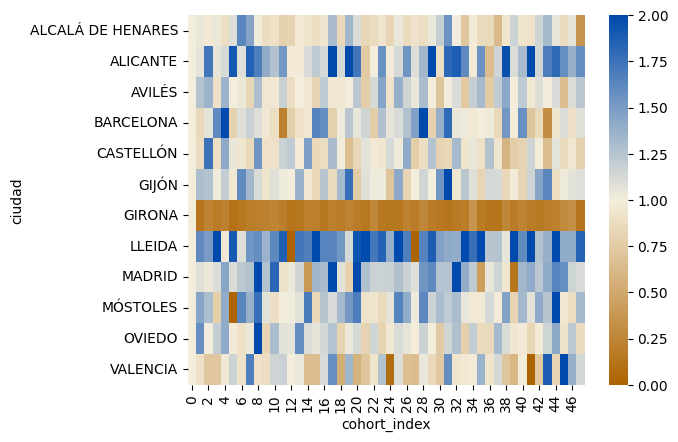

In [116]:
sns.heatmap(
    cohortes_ciudad,
    cmap = cmap,
    center = 1,
    vmax = 2,
    vmin = 0
)

In [136]:
cohortes_ciudad = (
    df
    .pivot_table(
        index = 'ciudad',
        columns = 'cohort_index',
        values = 'n_compras',
        aggfunc = 'mean'
    )
)
cohortes_ciudad = cohortes_ciudad.divide(cohortes_ciudad[0],axis=0)
cohortes_ciudad.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
ciudad,,,,,,,,,,,,,,,,,,,,,
ALCALÁ DE HENARES,1.0,0.563999,0.529771,0.574122,0.653828,0.659723,0.869997,0.605309,1.444195,0.750839,...,0.472094,0.587962,0.687463,0.621942,0.822109,0.636711,1.461951,0.778029,1.355413,1.636060
ALICANTE,1.0,0.610274,1.142583,0.800831,1.088330,0.519201,1.069658,0.584682,0.924581,1.481373,...,1.085290,0.825420,1.078185,0.552970,0.923217,0.830875,1.000095,1.621838,0.985489,2.423654
AVILÉS,1.0,0.407315,0.469183,0.870370,0.549282,0.391934,0.473904,0.826533,0.661112,1.695682,...,0.580961,0.753018,0.529863,0.393687,0.441867,0.884484,0.607972,1.520431,1.340295,1.157038
BARCELONA,1.0,0.393378,0.479705,0.450631,0.566185,1.523559,0.598838,0.487786,0.998013,0.653062,...,0.523426,0.456042,0.573964,1.194324,0.631778,0.468154,0.980938,0.664783,1.610787,1.134764
CASTELLÓN,1.0,0.641238,0.480935,0.581811,0.721891,0.806663,0.667994,0.634916,1.549743,1.448164,...,0.512042,0.527053,0.770390,0.691192,0.718731,0.735323,1.413297,1.553157,2.063460,1.755606


<Axes: xlabel='cohort_index', ylabel='ciudad'>

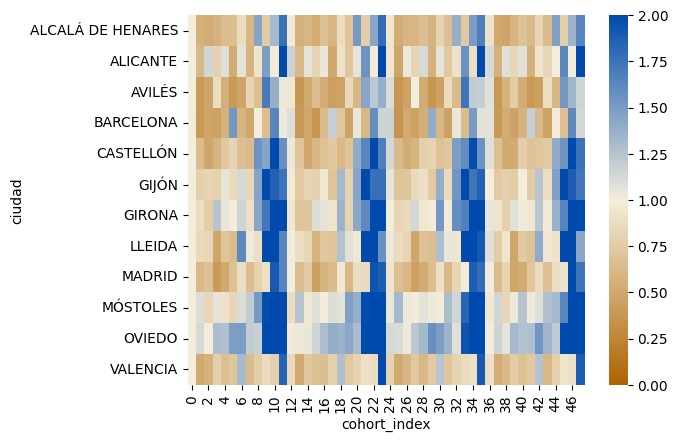

In [137]:
sns.heatmap(
    cohortes_ciudad,
    cmap = cmap,
    center = 1,
    vmax = 2,
    vmin = 0
)

In [145]:
cohortes_ciudad = (
    df
    .pivot_table(
        index = 'ciudad',
        columns = 'cohort_index',
        values = 'n_compras',
        aggfunc = 'mean'
    )
)
cohortes_ciudad = cohortes_ciudad.divide(cohortes_ciudad.shift(axis=1))

Text(0.5, 1.0, 'Variación de número de compras con respecto al mes anterior')

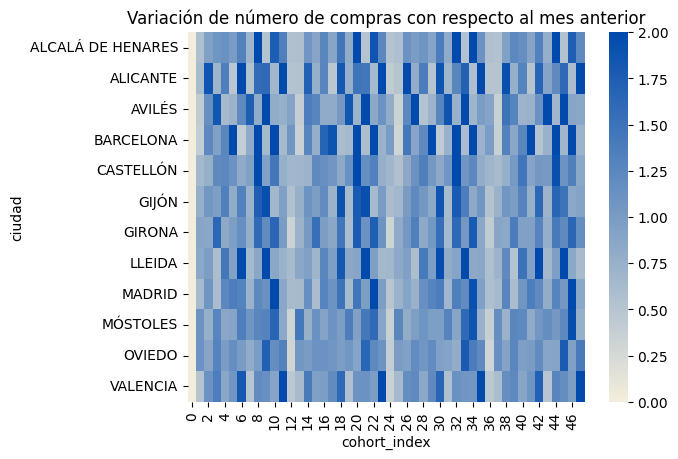

In [154]:
sns.heatmap(
    cohortes_ciudad.fillna(0),
    cmap = cmap,
    center = 0,
    vmax = 2
)
plt.title('Variación de número de compras con respecto al mes anterior')